In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder

sns.set(style="whitegrid")

train_df = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test_df = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)



Train shape: (28800, 60)
Test shape: (3, 58)


In [3]:
train_df.head()
train_df.describe()


,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs,efs_time
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,...,28800.000000,26410.000000,24712.00000,28323.000000,27930.00000,25147.000000,25448.000000,23736.000000,28800.000000,28800.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,...,38.663162,1.709087,1.69962,1.702327,83.83208,6.903448,1.707128,8.664687,0.539306,23.237678
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,...,21.147581,0.458259,0.46518,1.994443,11.02884,1.565017,0.461179,1.882746,0.498461,24.799748
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,...,0.044000,0.000000,0.00000,0.000000,40.00000,2.000000,0.000000,4.000000,0.000000,0.333000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,...,19.539000,1.000000,1.00000,0.000000,70.00000,6.000000,1.000000,7.000000,0.000000,5.619750
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,41.006000,2.000000,2.00000,1.000000,90.00000,8.000000,2.000000,10.000000,1.000000,9.796500
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,55.965250,2.000000,2.00000,2.000000,90.00000,8.000000,2.000000,10.000000,1.000000,35.100000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,73.726000,2.000000,2.00000,10.000000,100.00000,8.000000,2.000000,10.000000,1.000000,156.819000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


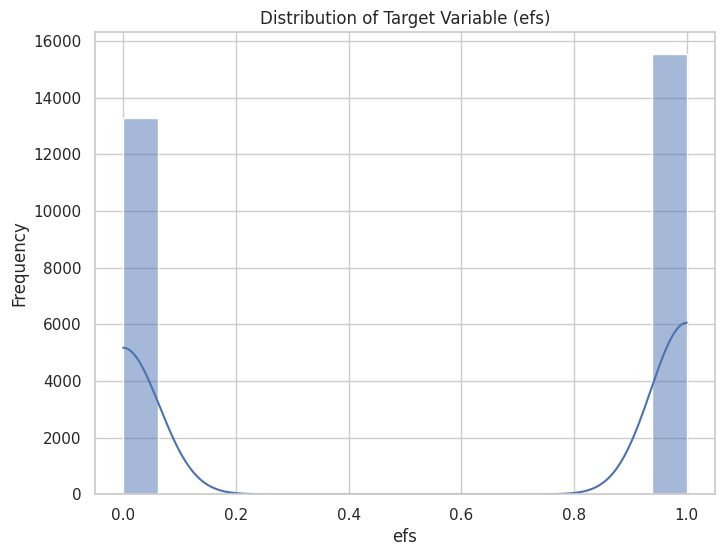

In [4]:
plt.figure(figsize=(8, 6))
sns.histplot(train_df['efs'], kde=True)
plt.title("Distribution of Target Variable (efs)")
plt.xlabel("efs")
plt.ylabel("Frequency")
plt.show()


In [5]:
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    train_df[col].fillna(train_df[col].median(), inplace=True)


cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_df[col].fillna("NaN", inplace=True)


for col in train_df.select_dtypes(include=['float64', 'int64']).columns:
    if col in test_df.columns:
        test_df[col].fillna(train_df[col].median(), inplace=True)
        
for col in train_df.select_dtypes(include=['object']).columns:
    if col in test_df.columns:
        test_df[col].fillna("NaN", inplace=True)

<ipython-input-5-500defe37d78>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
<ipython-input-5-500defe37d78>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [6]:
train_df.columns = train_df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
test_df.columns = test_df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)


In [7]:
X_train = train_df.drop(columns=['ID', 'efs'], errors='ignore')
y_train = train_df['efs']


In [8]:
X_test = test_df.drop(columns=['ID'], errors='ignore')

In [9]:
low_card_cols = [col for col in X_train.select_dtypes(include=['object']).columns if X_train[col].nunique() <= 10]
print("Low cardinality columns for one-hot encoding:", low_card_cols)


Low cardinality columns for one-hot encoding: ['psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [10]:
X_train = pd.get_dummies(X_train, columns=low_card_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=low_card_cols, drop_first=True)

In [11]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [12]:
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')


In [13]:
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')


In [14]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


In [15]:
for col in X_train.columns:
    if X_train[col].isnull().any():
        X_train[col].fillna(X_train[col].median(), inplace=True)
        
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test[col].fillna(X_test[col].median(), inplace=True)


<ipython-input-15-4c9b0d9a2d67>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(X_train[col].median(), inplace=True)
<ipython-input-15-4c9b0d9a2d67>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [16]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Training set shape:", X_tr.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (23040, 137)
Validation set shape: (5760, 137)


In [17]:

illegal_chars = r"[,\[\]<]"


X_train.columns = X_train.columns.str.replace(illegal_chars, "_", regex=True)
X_val.columns = X_val.columns.str.replace(illegal_chars, "_", regex=True)
X_tr.columns = X_tr.columns.str.replace(illegal_chars, "_", regex=True)  

X_test.columns = X_test.columns.str.replace(illegal_chars, "_", regex=True)


print("Cleaned feature names:")
print(X_train.columns.tolist())


Cleaned feature names:
['dri_score', 'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'prim_disease_hct', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'efs_time', 'psych_disturb_No', 'psych_disturb_Not done', 'psych_disturb_Yes', 'cyto_score_Intermediate', 'cyto_score_NaN', 'cyto_score_Normal', 'cyto_score_Not tested', 'cyto_score_Other', 'cyto_score_Poor', 'cyto_score_TBD', 'diabetes_No', 'diabetes_Not done', 'diabetes_Yes', 'tbi_status_TBI + Cy +- Other', 'tbi_status_TBI +- Other_ -cGy_ fractionated', 'tbi_status_TBI +- Other_ -cGy_ single', 'tbi_status_TBI +- Other_ -cGy_ unknown dose', 'tbi_status_TBI +- Other_ _=cGy', 'tbi_status_TBI +- Other_ >cGy', 'tbi_stat

In [18]:
X_test = X_test.astype(np.float32)



In [19]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score


model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=300,
                         max_depth=6,
                         learning_rate=0.01)


model.fit(X_tr, y_tr)  


y_val_pred = model.predict(X_val)
val_auc = roc_auc_score(y_val, y_val_pred)
print("Validation ROC AUC:", val_auc)


Validation ROC AUC: 0.9982172687576215


In [20]:
predictions = model.predict(X_test)
print("Prediction shape:", predictions.shape)


Prediction shape: (3,)


In [21]:

predictions = model.predict(X_test)
print("Prediction shape:", predictions.shape)

submission = pd.DataFrame({
    'ID': test_df['ID'],  
    'prediction': predictions
})

submission.to_csv('submission.csv', index=False, encoding='utf-8')
print("Submission file saved successfully!")


Prediction shape: (3,)
Submission file saved successfully!
